# Linear elasticity with PETSc

In this notebook, we solve a linear elastic problem using `PETSc` based solvers.

In [1]:
from typing import NamedTuple

import gmsh
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import Array
from jax_autovmap import autovmap
from tatva import Mesh, Operator
from tatva_coloring import distance2_color_and_seeds
from tatva import sparse

from petsc4py import PETSc

In [4]:
# [collapse: code] Code for generating a plate with a hole and plotting the mesh

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import meshio

import numpy as np
import os


def plot_mesh(mesh: Mesh, ax: Axes | None = None) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    ax.tripcolor(
        mesh.coords[:, 0],
        mesh.coords[:, 1],
        mesh.elements,
        facecolors=np.ones(len(mesh.elements)),
        cmap="managua",
        edgecolors="k",
        linewidth=0.2,
    )
   
    ax.set_aspect("equal")
    ax.margins(0.0)

def generate_refined_plate_with_hole(
    width: float,
    height: float,
    hole_radius: float,
    mesh_size_fine: float,
    mesh_size_coarse: float,
):
    mesh_dir = os.path.join(os.getcwd(), "../meshes")
    os.makedirs(mesh_dir, exist_ok=True)
    output_filename = os.path.join(mesh_dir, "plate_hole_refined.msh")

    gmsh.initialize()
    gmsh.model.add("plate_with_hole_refined")
    occ = gmsh.model.occ

    rect = occ.addRectangle(0, 0, 0, width, height)
    cx = width / 2.0
    cy = height / 2.0
    disk = occ.addDisk(cx, cy, 0, hole_radius, hole_radius)

    out, _ = occ.cut([(2, rect)], [(2, disk)])
    occ.synchronize()

    surface_tag = out[0][1]
    gmsh.model.addPhysicalGroup(2, [surface_tag], 1, name="domain")

    boundaries = gmsh.model.getBoundary(out, oriented=False)
    boundary_tags = [b[1] for b in boundaries]
    gmsh.model.addPhysicalGroup(1, boundary_tags, 2, name="boundaries")

    hole_curve_tags = []
    for tag in boundary_tags:
        xmin, ymin, zmin, xmax, ymax, zmax = gmsh.model.getBoundingBox(1, tag)
        # The hole is completely inside the outer rectangle
        if xmin > 0 and xmax < width and ymin > 0 and ymax < height:
            hole_curve_tags.append(tag)

    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "CurvesList", hole_curve_tags)
    gmsh.model.mesh.field.setNumber(1, "NumPointsPerCurve", 100)

    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "InField", 1)
    gmsh.model.mesh.field.setNumber(2, "SizeMin", mesh_size_fine)
    gmsh.model.mesh.field.setNumber(2, "SizeMax", mesh_size_coarse)
    # Start growing the mesh exactly at the hole boundary
    gmsh.model.mesh.field.setNumber(2, "DistMin", 0.0)
    # Reach maximum element size at a distance equal to 2 hole radii away
    gmsh.model.mesh.field.setNumber(2, "DistMax", hole_radius * 2.0)

    gmsh.model.mesh.field.setAsBackgroundMesh(2)

    gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
    gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
    gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)

    gmsh.model.mesh.generate(2)
    gmsh.write(output_filename)
    gmsh.finalize()

    _mesh = meshio.read(output_filename)
    coords = _mesh.points[:, :2]
    elements = _mesh.cells_dict["triangle"]

    return Mesh(coords=coords, elements=elements)

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.0205777s, CPU 0.017819s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0496628s, CPU 0.049729s)
Info    : 1874 nodes 3753 elements
Info    : Writing '/home/mohit/Documents/dev/tatva-docs/docs/external_solvers/../meshes/plate_hole_refined.msh'...
Info    : Done writing '/home/mohit/Documents/dev/tatva-docs/docs/external_solvers/../meshes/plate_hole_refined.msh'



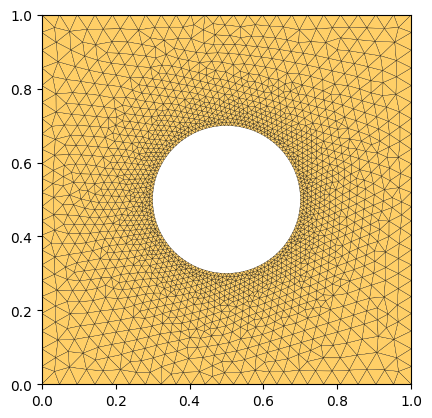

In [5]:
lx = 1.0
ly = 1.0
mesh = generate_refined_plate_with_hole(
    lx, ly, hole_radius=0.2, mesh_size_fine=0.01, mesh_size_coarse=0.05
)

n_dofs_per_node = 2
n_dofs = mesh.coords.shape[0] * n_dofs_per_node

plot_mesh(mesh)

## Problem setup


In [6]:
from tatva.element import Tri3

op = Operator(mesh, Tri3())


boundary_left = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
boundary_right = jnp.where(jnp.isclose(mesh.coords[:, 0], lx))[0]
point_at_y_0 = jnp.where(
    jnp.isclose(mesh.coords[:, 0], lx) & jnp.isclose(mesh.coords[:, 1], 0.0)
)[0][0]
assert point_at_y_0

fixed_dofs = jnp.concatenate(
    [
        boundary_left * n_dofs_per_node,
    ]
)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


## Defining energy functional

We now define the functions to compute the total strain energy


In [7]:
class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  
    lmbda: float

    @classmethod
    def from_youngs_poisson_2d(
        cls, E: float, nu: float, plane_stress: bool = False
    ) -> "Material":
        mu = E / 2 / (1 + nu)
        if plane_stress:
            lmbda = 2 * nu * mu / (1 - nu)
        else:
            lmbda = E * nu / (1 - 2 * nu) / (1 + nu)
        return cls(mu=mu, lmbda=lmbda)


mat = Material.from_youngs_poisson_2d(1, 0.3)


@autovmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


@autovmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    return 2 * mu * eps + lmbda * jnp.trace(eps) * jnp.eye(2)


@autovmap(grad_u=2, mu=0, lmbda=0)
def strain_energy_density(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sigma, eps)


## Enforcing boundary condition via static condensation

In [8]:
@jax.jit
def total_energy_full(u_flat: Array) -> Array:
    """Compute the total energy of the system."""
    u = u_flat.reshape(-1, 2)
    u_grad = op.grad(u)
    e_density = strain_energy_density(u_grad, mat.mu, mat.lmbda)
    return op.integrate(e_density)


@jax.jit
def total_energy(u_free: Array, applied_disp: Array) -> Array:
    """Compute the total energy of the system."""
    u_full = jnp.zeros(n_dofs).at[free_dofs].set(u_free)
    u_full = u_full.at[fixed_dofs].set(applied_disp)
    return total_energy_full(u_full)


residual = jax.jacrev(total_energy)

Now we can define the `sparsity_pattern` and use `sparse.jacfwd` to create a function that computes the sparse stiffness matrix using sparse differentiation.

In [9]:
import scipy

nb_dofs_per_node = 2

sparsity_pattern = sparse.create_sparsity_pattern(
    mesh, n_dofs_per_node=nb_dofs_per_node
)

reduced_sparsity_pattern = sparse.reduce_sparsity_pattern(sparsity_pattern, free_dofs)
reduced_sparsity_pattern_csr = scipy.sparse.csr_matrix(
    (
        reduced_sparsity_pattern.data,
        (
            reduced_sparsity_pattern.indices[:, 0],
            reduced_sparsity_pattern.indices[:, 1],
        ),
    )
)

colors = distance2_color_and_seeds(
    reduced_sparsity_pattern_csr.indptr,
    reduced_sparsity_pattern_csr.indices,
    n_dofs=len(free_dofs),
)[0]

In [10]:
hessian_fn = sparse.jacfwd(
    gradient=residual,
    row_ptr=reduced_sparsity_pattern_csr.indptr,
    col_indices=reduced_sparsity_pattern_csr.indices,
    colors=colors,
    color_batch_size=len(jnp.unique(colors)) + 1,
)

## Defining the loading traction on right edge

We define a new `Operator` consisting of line elements along the right edge and then use this `op_line` to integrate the traction along the nodes.

In [11]:
sig_loading = 1e-2

f_ext_0 = jnp.zeros(n_dofs)

idx_right = n_dofs_per_node * boundary_right

f_ext_0 = f_ext_0.at[idx_right].add(sig_loading)
f_ext = f_ext_0.at[free_dofs].get()

Now let us solve the linear problem using `PETSc`

$$
\mathbf{K}\boldsymbol{u} =\boldsymbol{f}_\text{ext}
$$

We will use the above defined `hessian_fn` to compute the sparse stiffness matrix and will convert it to `PETSc.Mat.AIJ` which is the the sparse matrix representation.

In [12]:
K_bcco = hessian_fn(jnp.zeros(len(free_dofs)), applied_disp=jnp.zeros(len(fixed_dofs)))
petsc_mat = PETSc.Mat().createAIJ(
    size=K_bcco.shape,
    csr=(
        reduced_sparsity_pattern_csr.indptr,
        reduced_sparsity_pattern_csr.indices,
        K_bcco.data,
    ),
)

## Setting up PETSc solver (Direct Linear Solver)

We first set a Direct Linear Solver in PETSc.

In [15]:
ksp = PETSc.KSP().create()
ksp.setOperators(petsc_mat)
ksp.setType('preonly')
ksp.setConvergenceHistory()
ksp.getPC().setType('lu')

We can now solve the linear system for the applied $\boldsymbol{f}_\text{ext}$

In [ ]:
du = petsc_mat.createVecRight()
b = petsc_mat.createVecLeft()
b.setArray(f_ext)
ksp.solve(b, du)

## Visualization and analyzing the results


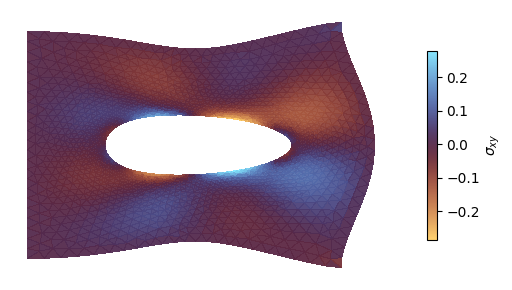

In [42]:
# [collapse: code] Code to visualize the results

from matplotlib.tri import Triangulation

u = jnp.zeros(n_dofs).at[free_dofs].set(du.getArray())
u = u.reshape(-1, 2)

fig, ax = plt.subplots(figsize=(7.4, 3))
x_final = mesh.coords + u
tri = Triangulation(x_final[:, 0], x_final[:, 1], mesh.elements)

sig = compute_stress(compute_strain(op.grad(u)), mat.mu, mat.lmbda).squeeze()


def plot_field(ax: Axes):
    cb = ax.tripcolor(
        tri,
        sig[..., 0, 1],
        alpha=0.95,
        rasterized=True,
        cmap="managua",
    )
    ax.set_aspect("equal")
    ax.set(
        xlabel="$x$",
        ylabel="$y$",
    )
    return cb


cb = plot_field(ax)
ax.set_axis_off()
plt.colorbar(cb, ax=ax, label=r"$\sigma_{xy}$", shrink=0.7)
fig.tight_layout()

## Setting up PETSc Solver (Iterative Solver)

We will use a `Conjugate Gradient` solver from `PETSc`. Although, here we will directly use the sparse matrix and pass it on to `PETSc`. 

!!! Info

    Ideally, we should use the `JVP` and set the function.

In [25]:
ksp = PETSc.KSP().create()
ksp.setOperators(petsc_mat)
ksp.setType('cg')
ksp.setConvergenceHistory()
ksp.getPC().setType('none')


We can now solve the linear system for the applied $\boldsymbol{f}_\text{ext}$

In [26]:
du = petsc_mat.createVecRight()
b = petsc_mat.createVecLeft()
b.setArray(f_ext)

ksp.solve(b, du)

Lets see how the error evolved during the iterations.

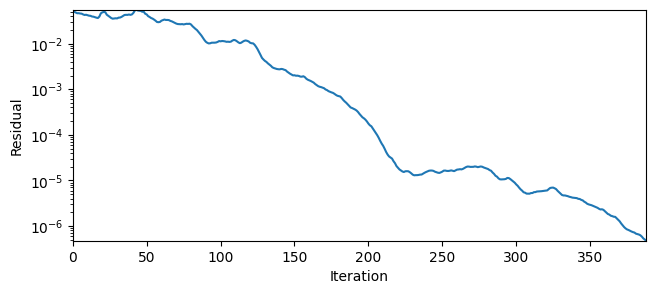

In [27]:
# [collapse: code] Code to visualize the convergence history

residuals = ksp.getConvergenceHistory()

plt.figure(figsize=(7.4, 3))
plt.semilogy(residuals)
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.gca().margins(0.0)
plt.show()

We can visualize the deformation of the plate and it should be identical to the previous result.

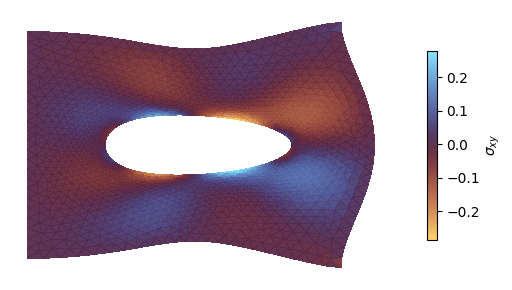

In [46]:
# [collapse: code] Code to visualize the results

from matplotlib.tri import Triangulation

u = jnp.zeros(n_dofs).at[free_dofs].set(du.getArray())
u = u.reshape(-1, 2)

fig, ax = plt.subplots(figsize=(7.4, 3))
x_final = mesh.coords + u
tri = Triangulation(x_final[:, 0], x_final[:, 1], mesh.elements)

sig = compute_stress(compute_strain(op.grad(u)), mat.mu, mat.lmbda).squeeze()


def plot_field(ax: Axes):
    cb = ax.tripcolor(
        tri,
        sig[..., 0, 1],
        alpha=0.95,
        rasterized=True,
        cmap="managua",
    )
    ax.set_aspect("equal")
    ax.set(
        xlabel="$x$",
        ylabel="$y$",
    )
    return cb


cb = plot_field(ax)
ax.set_axis_off()
plt.colorbar(cb, ax=ax, label=r"$\sigma_{xy}$", shrink=0.7)
fig.tight_layout()